To ensure that every samples has GO annotations that represent a complete subgraph of the Gene Ontology, we'll leverage the hierarchical structure of the GO DAG to include terms of any missing descendants.

/home/andrew/Workspace/AmiGO/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


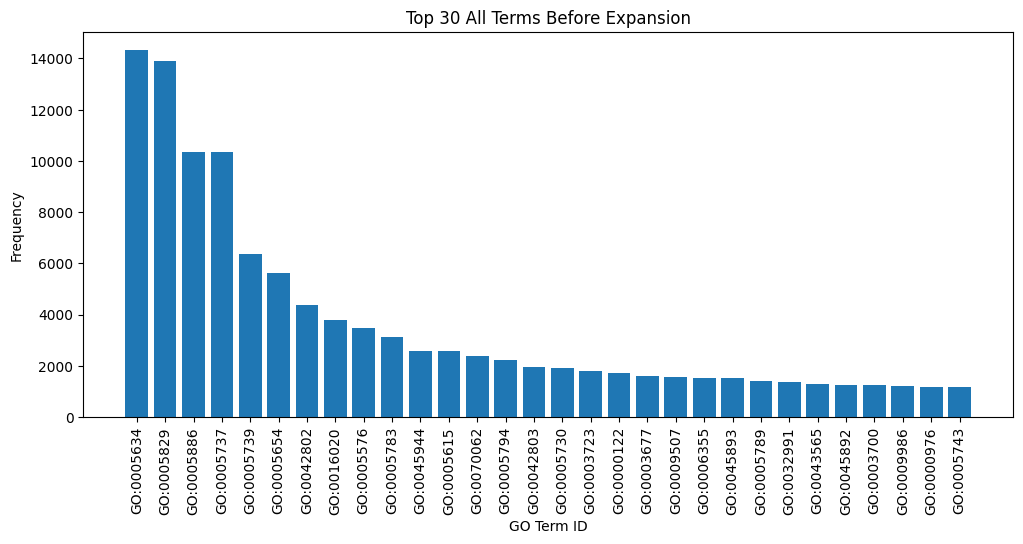

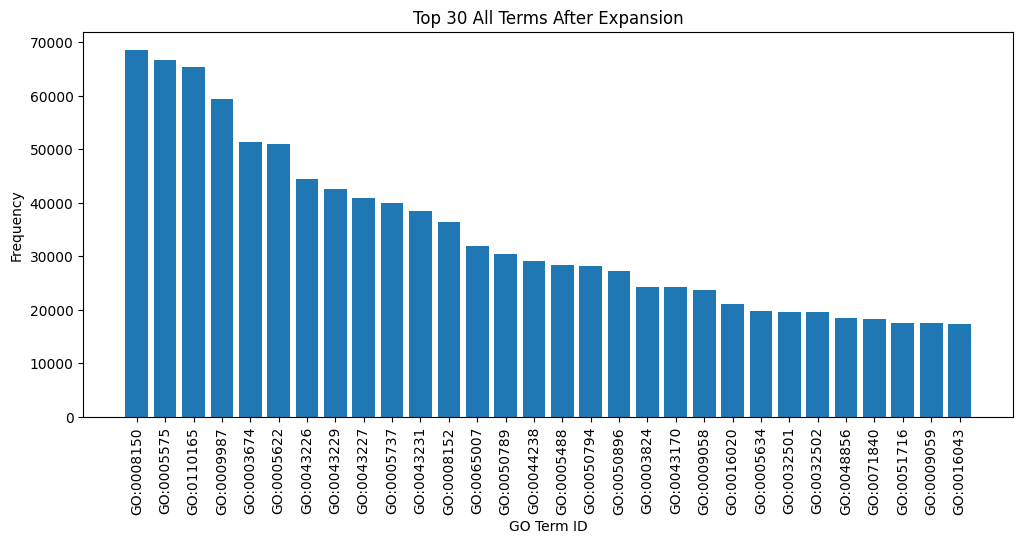

Total terms before/after: 555,298/4,348,739
Unique terms before/after: 26,754/30,274
Average terms before/after: 20.76/143.65


Dataset saved to ./dataset/all-expanded.jsonl


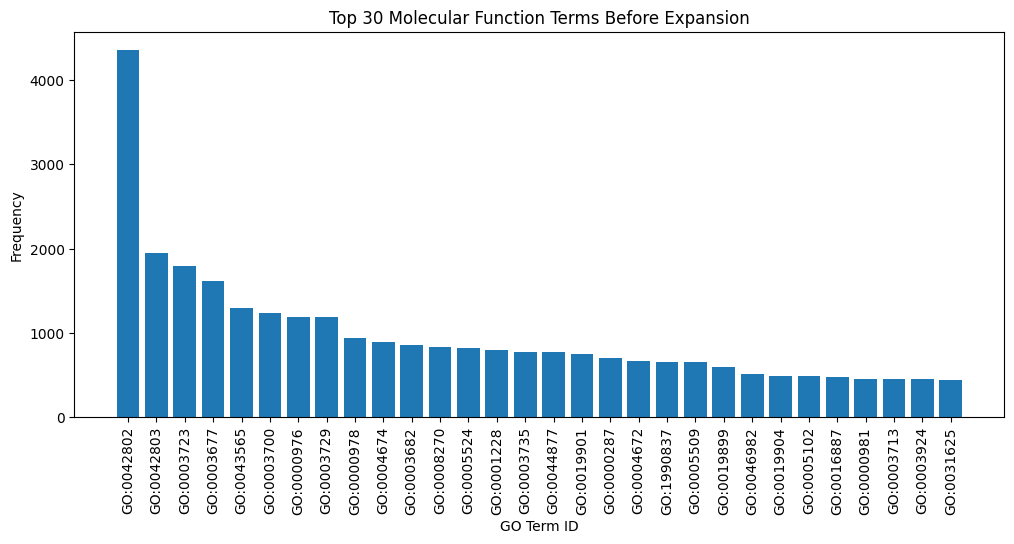

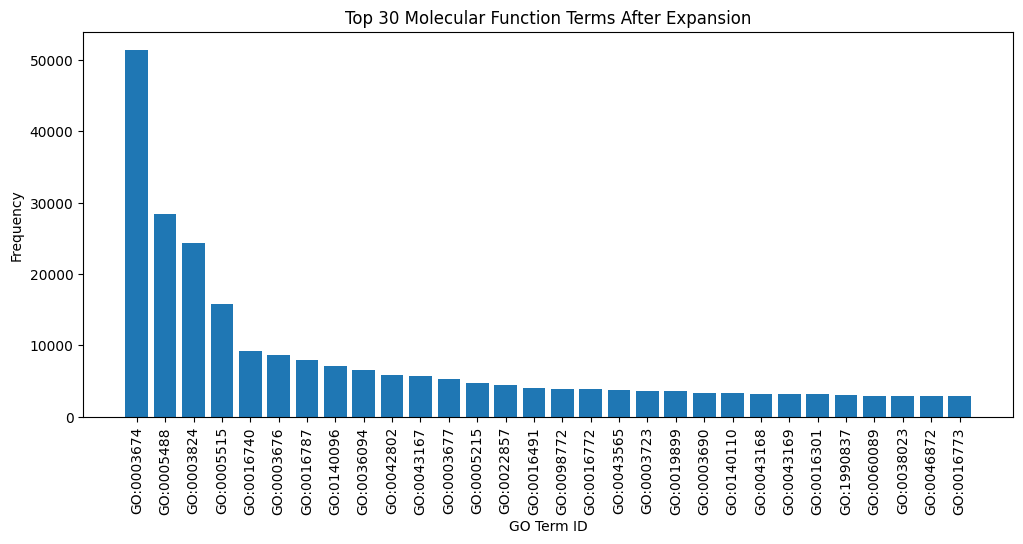

Total terms before/after: 105,306/549,319
Unique terms before/after: 6,847/7,173
Average terms before/after: 15.38/76.58


Dataset saved to ./dataset/mf-expanded.jsonl


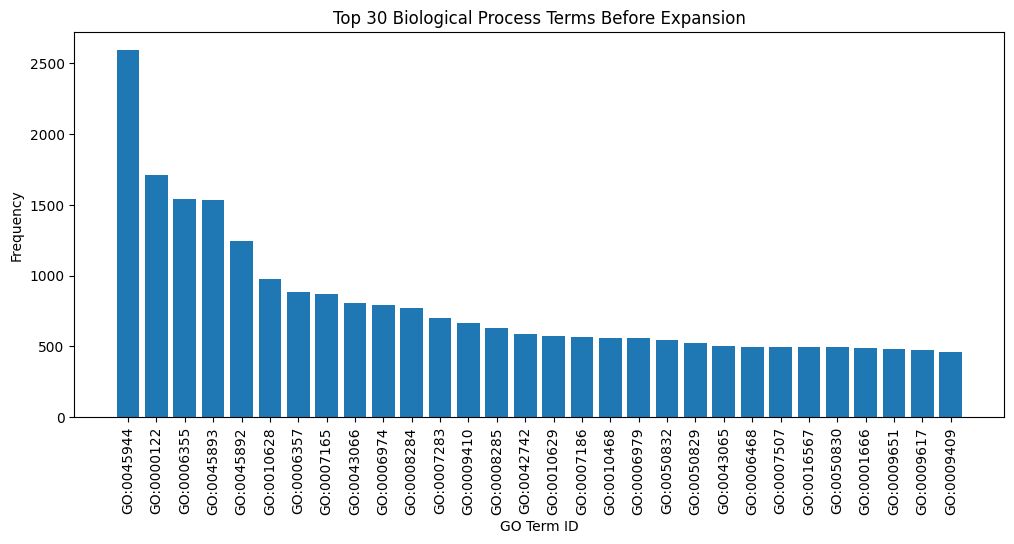

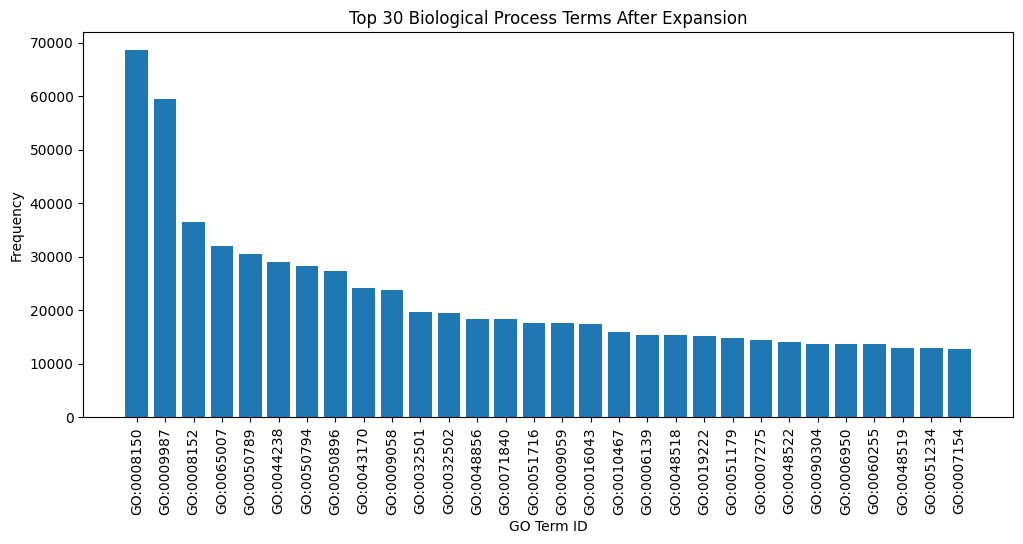

Total terms before/after: 278,160/2,882,996
Unique terms before/after: 17,172/20,181
Average terms before/after: 16.20/142.86


Dataset saved to ./dataset/bp-expanded.jsonl


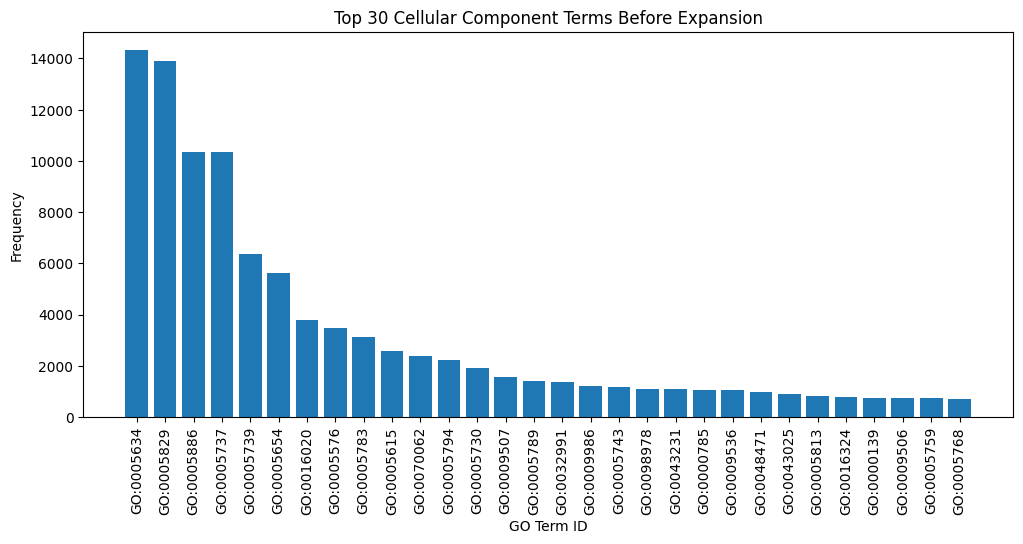

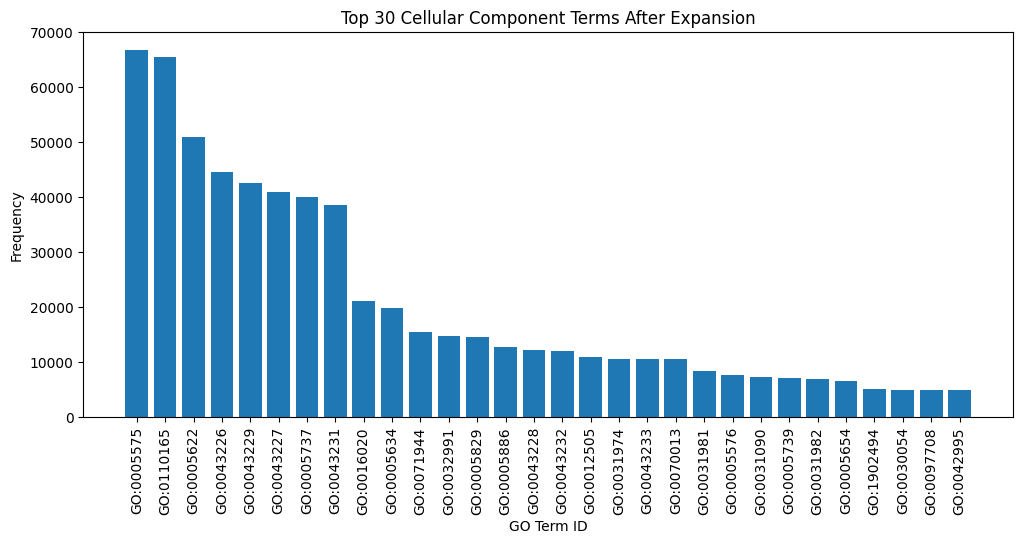

Total terms before/after: 171,832/916,424
Unique terms before/after: 2,735/2,920
Average terms before/after: 62.83/313.84


Dataset saved to ./dataset/cc-expanded.jsonl


In [1]:
from datasets import load_dataset

import obonet

import networkx as nx

from collections import Counter

from itertools import islice

import matplotlib.pyplot as plt

import json

all_dataset_path = "./dataset/all-filtered.jsonl"
mf_dataset_path = "./dataset/mf-filtered.jsonl"
bp_dataset_path = "./dataset/bp-filtered.jsonl"
cc_dataset_path = "./dataset/cc-filtered.jsonl"

all_expanded_path = "./dataset/all-expanded.jsonl"
mf_expanded_path = "./dataset/mf-expanded.jsonl"
bp_expanded_path = "./dataset/bp-expanded.jsonl"
cc_expanded_path = "./dataset/cc-expanded.jsonl"

top_k = 30

# Download the OBO file from https://geneontology.org/docs/download-ontology.
go_obo_path = "./dataset/go-basic.obo"

graph = obonet.read_obo(go_obo_path)

assert nx.is_directed_acyclic_graph(graph), "Invalid GO graph, use basic DAG."

for name, dataset_path, expanded_path in [
    ("All", all_dataset_path, all_expanded_path),
    ("Molecular Function", mf_dataset_path, mf_expanded_path),
    ("Biological Process", bp_dataset_path, bp_expanded_path),
    ("Cellular Component", cc_dataset_path, cc_expanded_path),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    before_counter = Counter()
    after_counter = Counter()

    with open(expanded_path, "w") as file:
        for record in dataset:
            original_terms = set(record["go_terms"])

            for term in original_terms:
                before_counter[term] += 1

            expanded_terms = set()

            for node in original_terms:
                expanded_terms.add(node)

                if node in graph:
                    for descendant in nx.descendants(graph, node):
                        expanded_terms.add(descendant)

            for term in expanded_terms:
                after_counter[term] += 1
            
            record["go_terms"] = list(expanded_terms)

            file.write(json.dumps(record) + "\n")

    for when, counter, in (("Before", before_counter), ("After", after_counter)):
        counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse=True))

        first_k = dict(islice(counter.items(), top_k))

        plt.figure(figsize=(12, 5)) 

        plt.bar(first_k.keys(), first_k.values())

        plt.title(f"Top {top_k} {name} Terms {when} Expansion")
        plt.xticks(rotation=90)
        plt.xlabel("GO Term ID")
        plt.ylabel("Frequency")

        plt.show()

    total_before = before_counter.total()
    total_after = after_counter.total()

    unique_before = len(before_counter)
    unique_after = len(after_counter)

    average_before = total_before / unique_before
    average_after = total_after / unique_after

    print(f"Total terms before/after: {total_before:,}/{total_after:,}")
    print(f"Unique terms before/after: {unique_before:,}/{unique_after:,}")
    print(f"Average terms before/after: {average_before:.2f}/{average_after:.2f}")

    print("\n")

    print(f"Dataset saved to {expanded_path}")
                

Now let's plot a few subgraphs as a sanity check.

Generating train split: 91220 examples [00:00, 535612.97 examples/s]


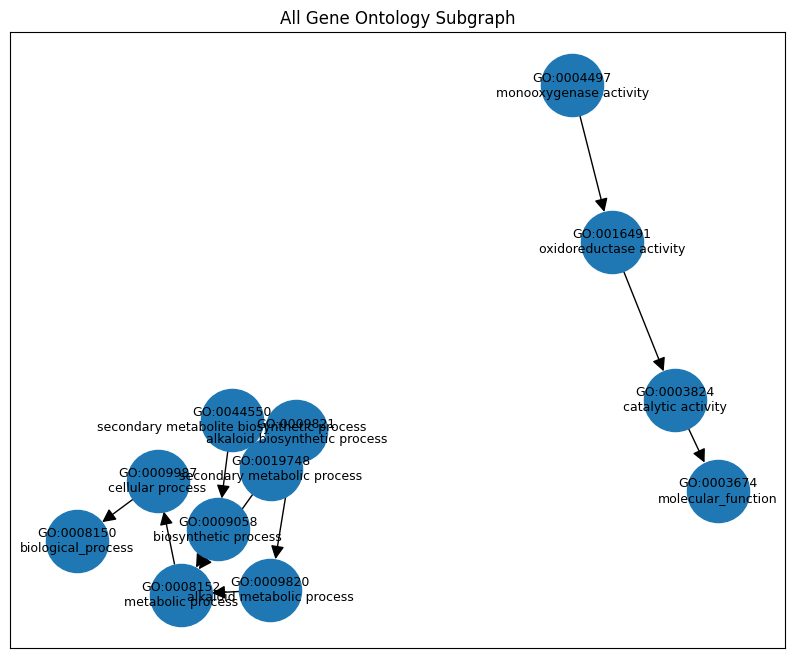

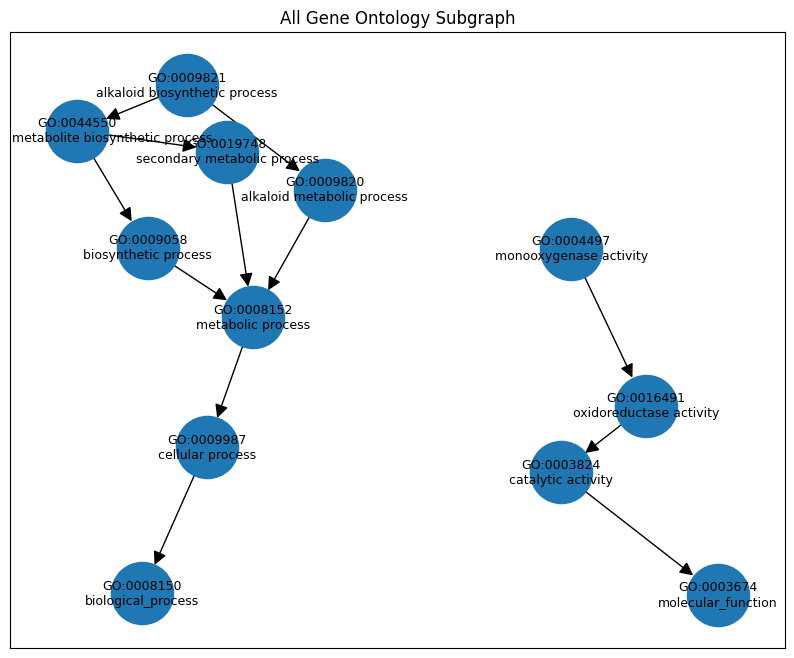

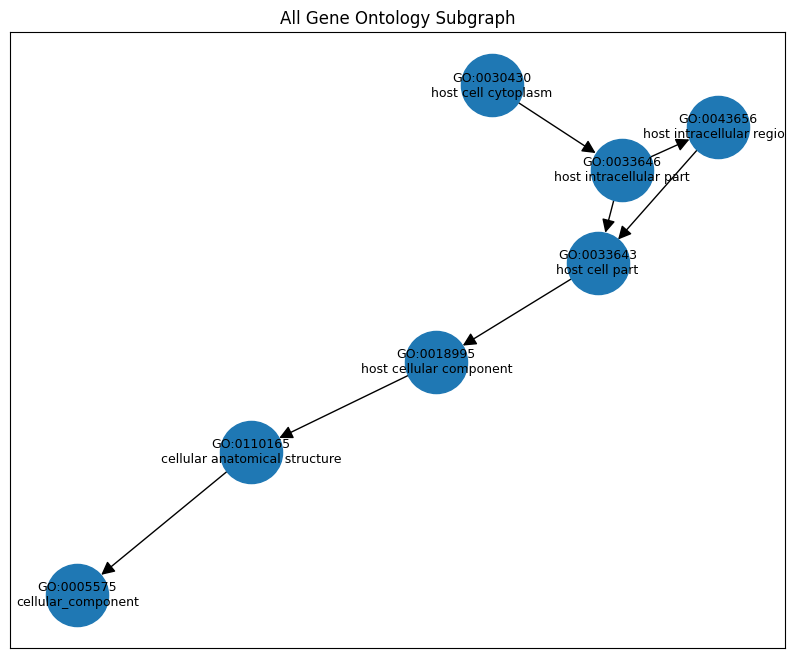

Generating train split: 51403 examples [00:00, 808422.48 examples/s]


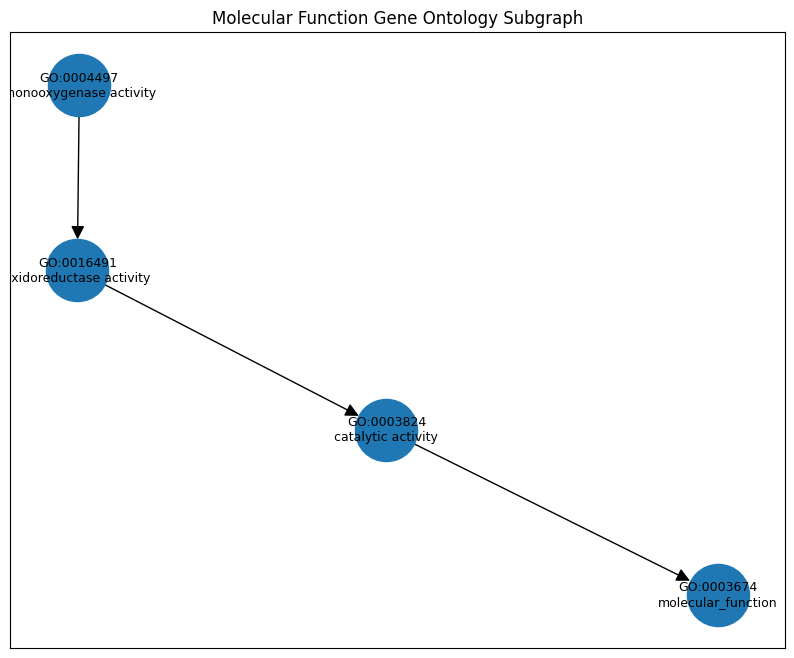

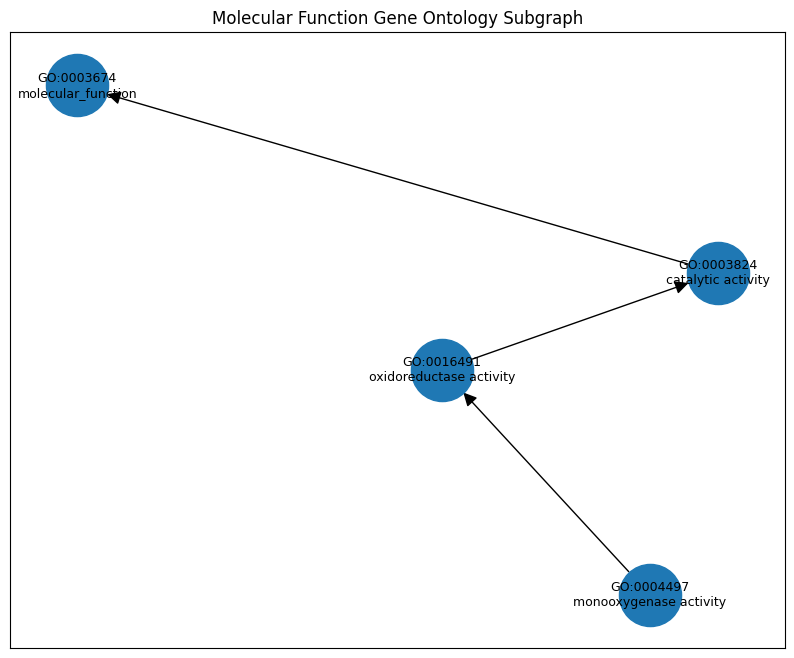

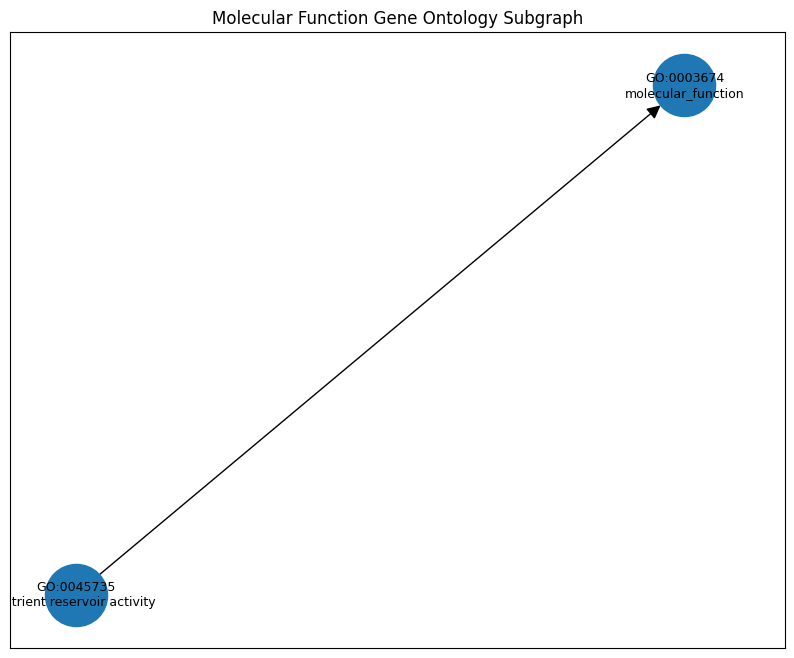

Generating train split: 68638 examples [00:00, 599606.85 examples/s]


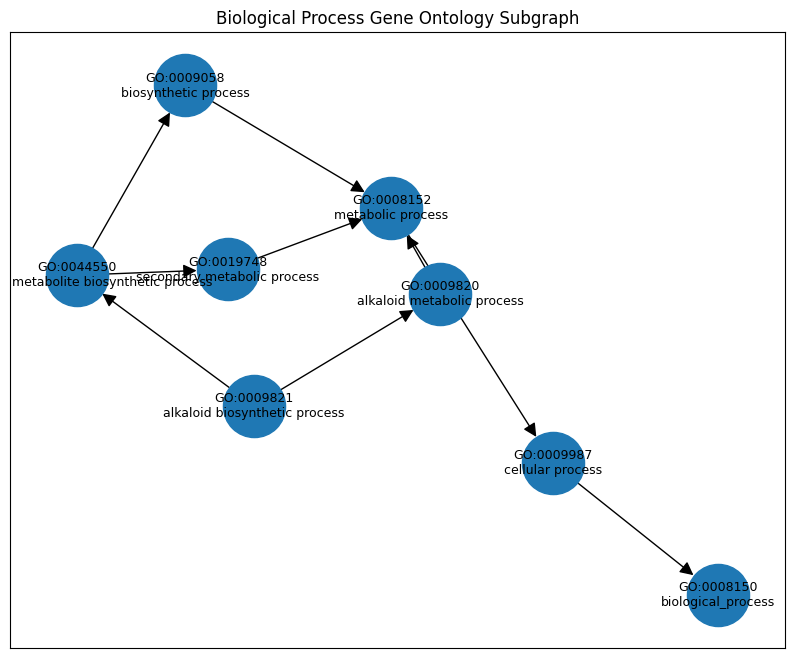

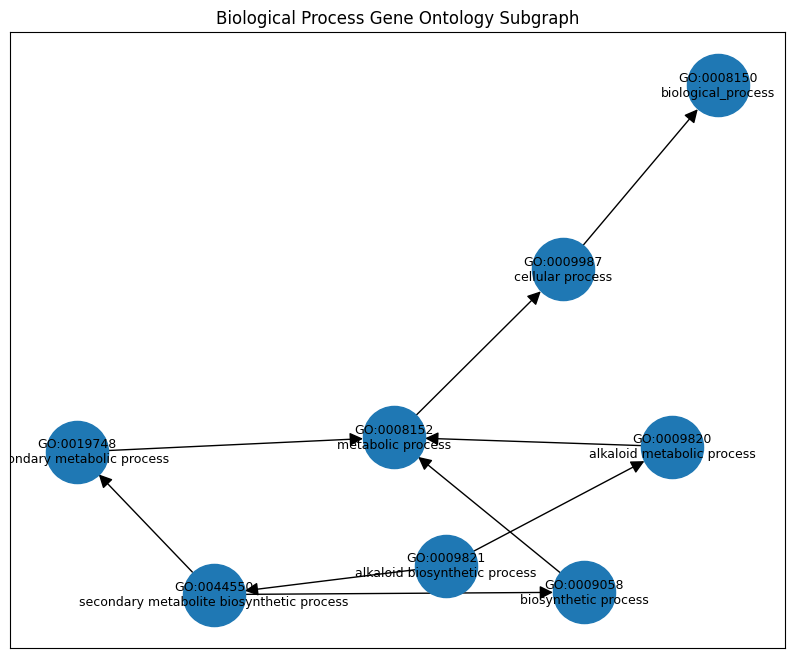

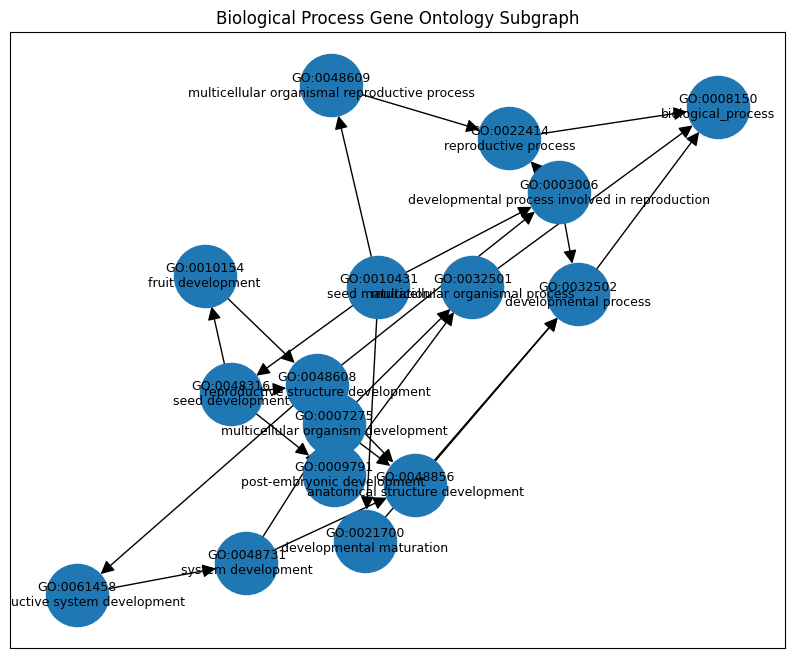

Generating train split: 66702 examples [00:00, 863173.88 examples/s]


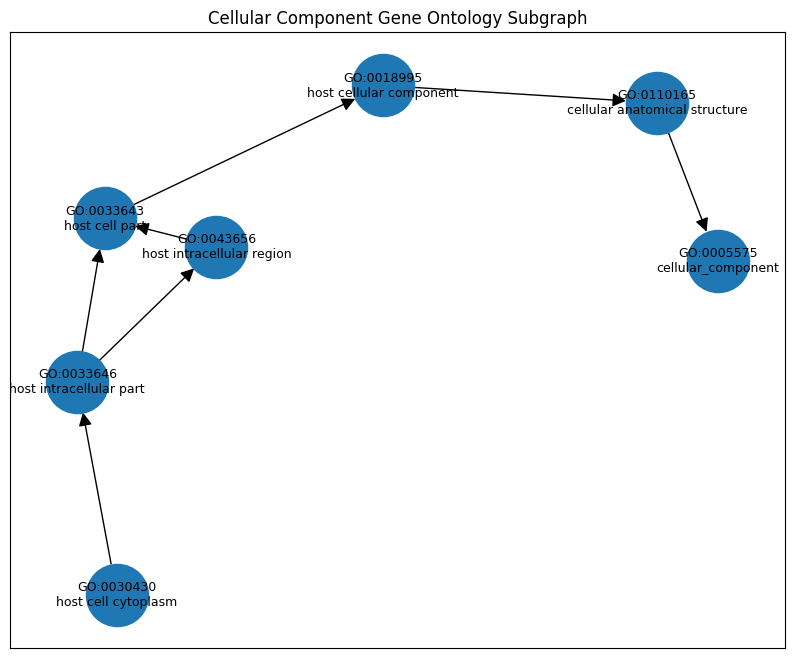

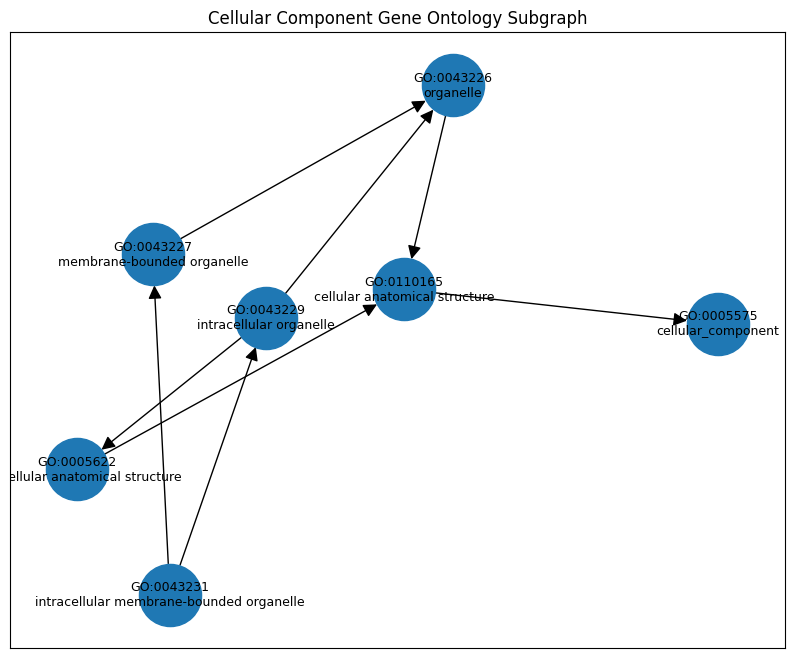

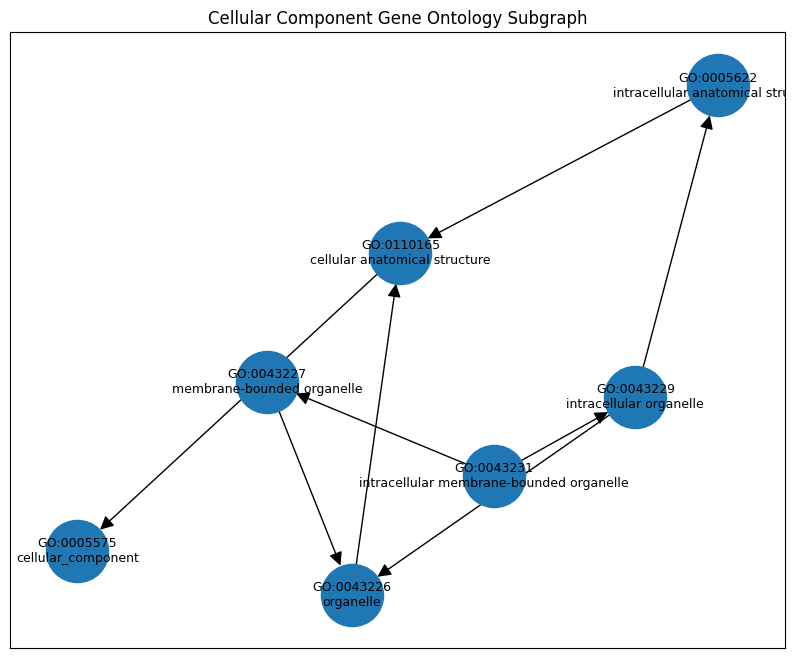

In [2]:
from functools import partial

from itertools import islice


all_dataset_path = "./dataset/all-expanded.jsonl"
mf_dataset_path = "./dataset/mf-expanded.jsonl"
bp_dataset_path = "./dataset/bp-expanded.jsonl"
cc_dataset_path = "./dataset/cc-expanded.jsonl"

plot_subgraph = partial(
    nx.draw_networkx,
    node_size=2000,
    font_size=9,
    with_labels=True,
    arrowsize=20,
)

for name, dataset_path, in [
    ("All", all_dataset_path),
    ("Molecular Function", mf_dataset_path),
    ("Biological Process", bp_dataset_path),
    ("Cellular Component", cc_dataset_path),
]:
    dataset = load_dataset("json", data_files=dataset_path, split="train")

    first_3 = list(islice(dataset, 3))

    for record in first_3:
        subgraph = graph.subgraph(record["go_terms"])

        labels = {
            go_term: f"{go_term}\n{data["name"]}"
            for go_term, data in subgraph.nodes(data=True)
        }

        plt.figure(figsize=(10, 8))
        plt.title(f"{name} Gene Ontology Subgraph")

        plot_subgraph(subgraph, labels=labels)

        plt.show()